In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new, predict_r0_multipliers, save_r0_mul
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
#from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles, plot_r0_multipliers

import yaml

In [10]:
predictions_dict = {}

In [11]:
config_filename = 'weights.yaml'
config = read_config(config_filename)

In [12]:
output_folder = '../../misc/reports/{}'.format(datetime.datetime.now().strftime("%Y_%m%d_%H%M%S"))

## Perform M1 and M2 fits

Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_12102020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 153                 | 154                 | 155                 | 156                 | 157                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-09-27 00:00:00 | 2020-09-28 00:00:00 | 2020-09-29 00:00:00 | 2020-09-30 00:00:00 | 2020-10-01 00:00:00 |
| state       | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         |
| district    | Mumbai              | Mumbai              | Mumbai              | Mumbai              | Mumbai              |
| total       | 198706.29           | 200876.71           | 201972.33           | 203049.8            | 204100.75  

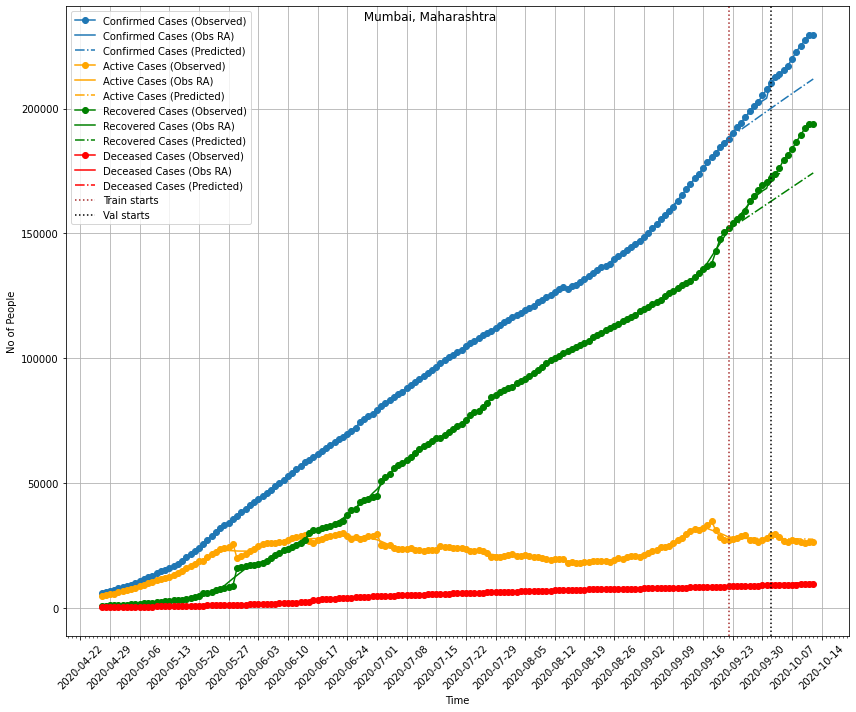

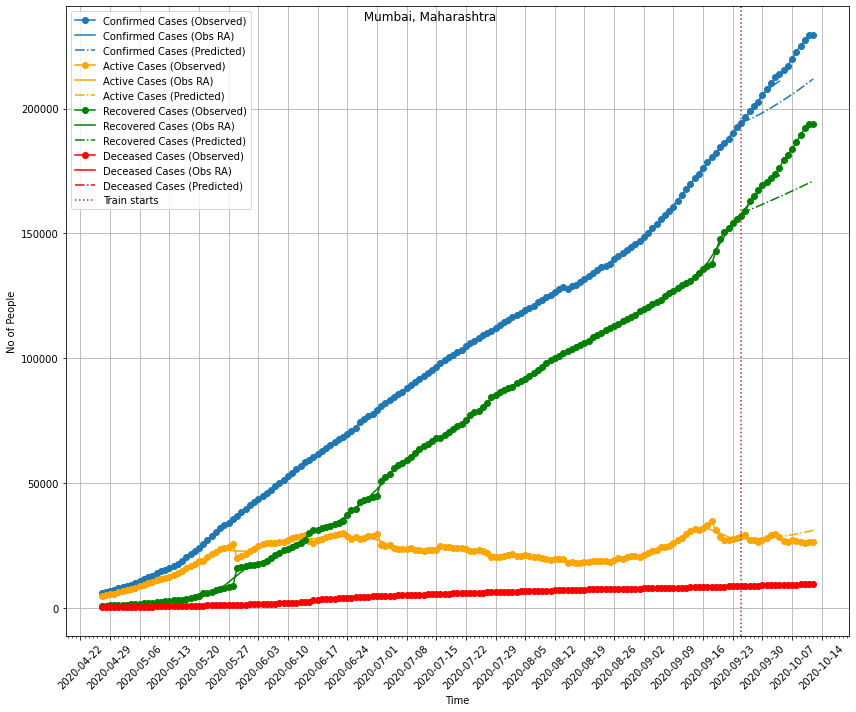

In [13]:
predictions_dict['m1'] = single_fitting_cycle(**copy.deepcopy(config['fitting'])) 

m2_params = copy.deepcopy(config['fitting'])
m2_params['split']['val_period'] = 0
predictions_dict['m2'] = single_fitting_cycle(**m2_params)

predictions_dict['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")

In [14]:
predictions_dict['m1']['best_params']

{'E_hosp_ratio': 0.22962000287808237,
 'I_hosp_ratio': 0.12050493148599481,
 'P_fatal': 0.04050262502249926,
 'T_inc': 4.763875525965271,
 'T_inf': 3.293971824257274,
 'T_recov': 23.723030598955148,
 'T_recov_fatal': 8.904046629946528,
 'lockdown_R0': 1.1402985625636242}

In [15]:
predictions_dict['m2']['best_params']

{'E_hosp_ratio': 0.20705163037544105,
 'I_hosp_ratio': 0.058415268733340964,
 'P_fatal': 0.0924045110118951,
 'T_inc': 4.407008539391494,
 'T_inf': 3.657607337538727,
 'T_recov': 33.66875234100646,
 'T_recov_fatal': 39.046033523935876,
 'lockdown_R0': 1.4323248193827847}

## Loss Dataframes

### M1 Loss DataFrame

In [16]:
predictions_dict['m1']['df_loss']

train      val
total       45.371  25.1673
active     114.011  100.429
recovered  37.6989  40.8752
deceased   112.454  52.2645

### M2 Loss DataFrame

In [17]:
predictions_dict['m2']['df_loss']

train
total      56.3849
active     104.352
recovered  61.2291
deceased   49.7208

## Sensitivity Plot

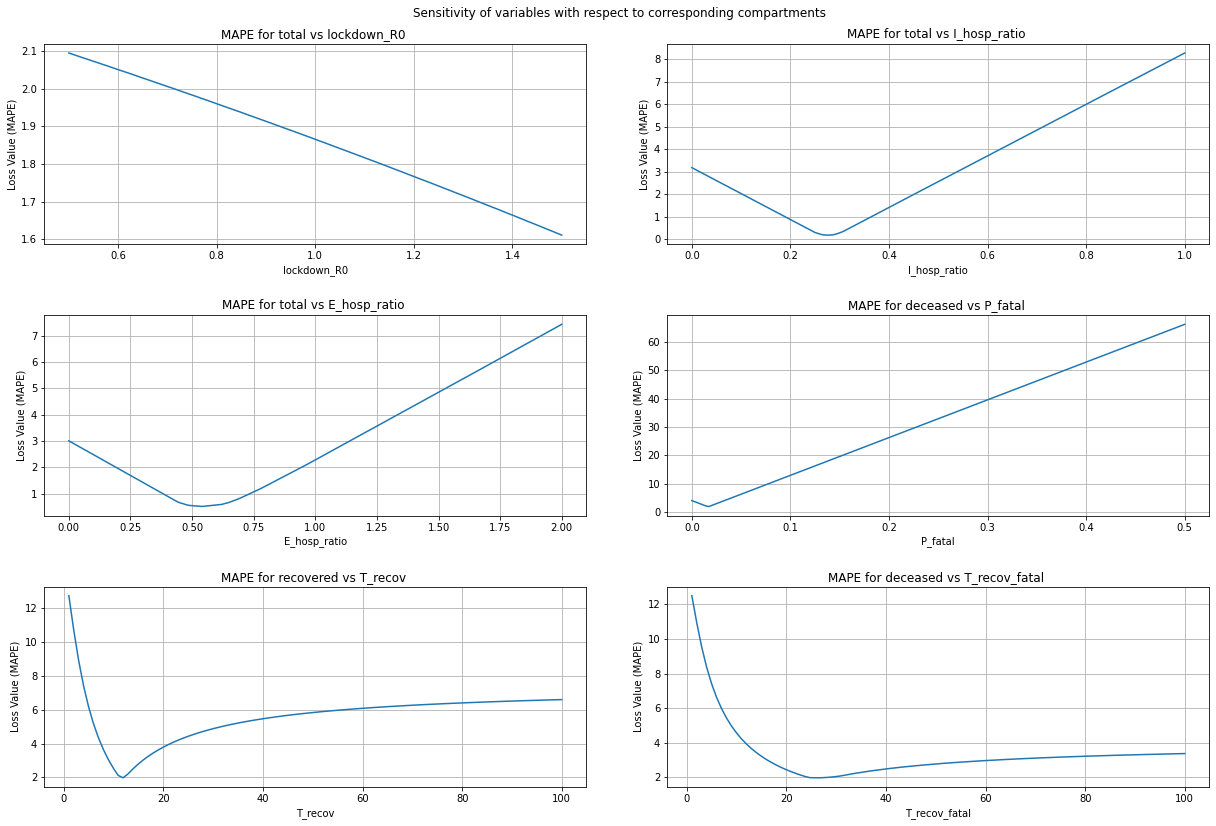

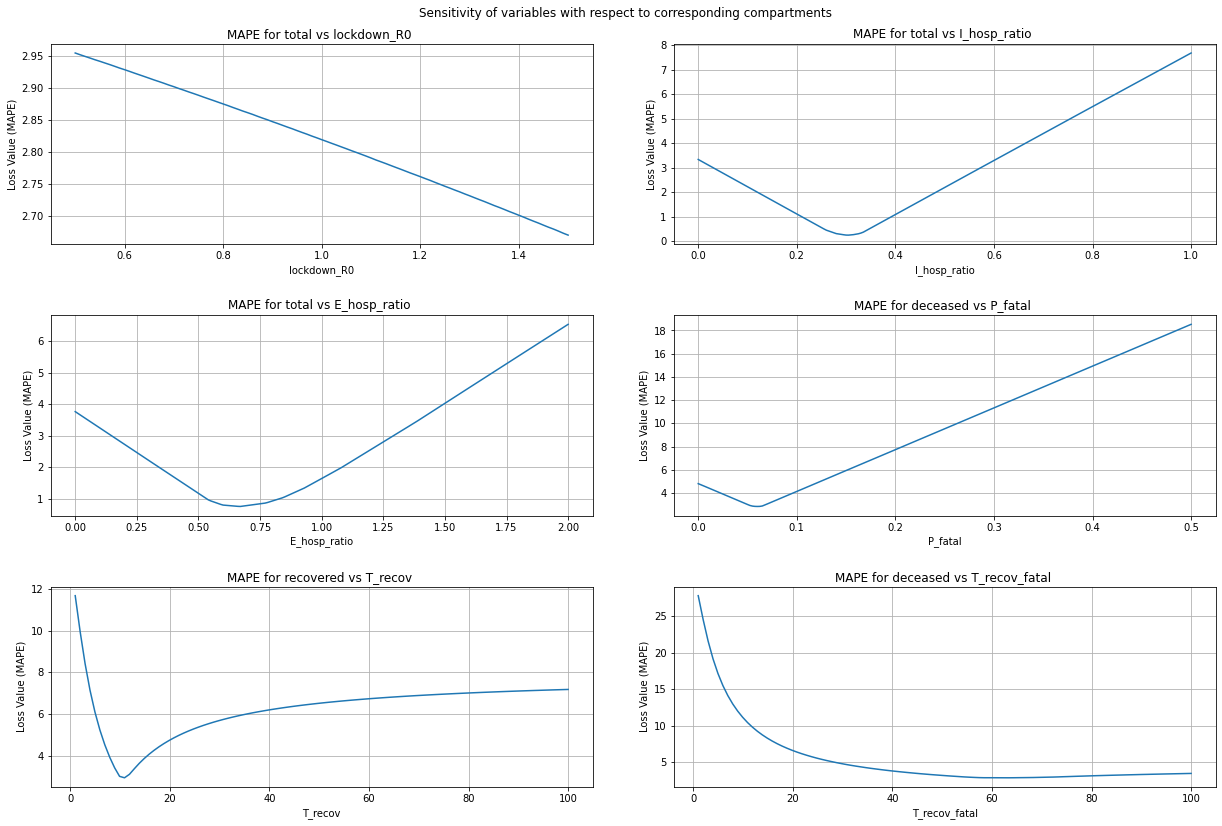

In [18]:
predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m1')
predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m2')

## Plot Forecasts

In [19]:
# M2 based forecasting for the next train_period + test_period + forecast_period (no validation period)
predictions_dict['m2']['forecasts'] = {}
predictions_dict['m2']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m2', 
                                                           model=config['fitting']['model'], 
                                                           days=config['forecast']['forecast_days'])

getting forecasts ..


[         date        S      E      I  R_recov  R_fatal       C      D  active  \
0  2020-09-25  1198142   5768   1627    25285     2574  157901   8700   27859   
1  2020-09-26  1197472   5200   2318    25035     2559  158647   8765   27594   
2  2020-09-27  1196617   4912   2763    24927     2558  159389   8831   27485   
3  2020-09-28  1195639   4792   3062    24912     2566  160129   8896   27478   
4  2020-09-29  1194577   4770   3278    24960     2580  160870   8962   27540   
..        ...      ...    ...    ...      ...      ...     ...    ...     ...   
58 2020-11-22  1077819  13547  10727    56960     6304  220112  14528   63264   
59 2020-11-23  1074569  13705  10867    57932     6414  221818  14691   64346   
60 2020-11-24  1071288  13860  11004    58911     6525  223552  14856   65436   
61 2020-11-25  1067976  14010  11139    59893     6636  225317  15025   66529   
62 2020-11-26  1064634  14157  11271    60880     6748  227110  15196   67628   

    recovered  deceased   

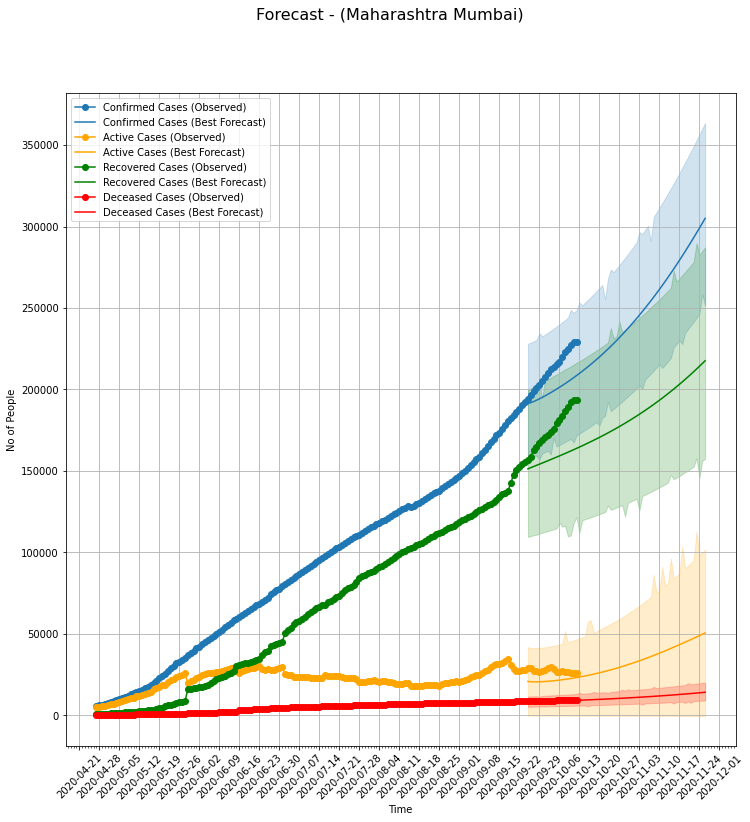

In [20]:
# Predictions plotted are for the most recent train_period days + test_period + forecast_period (no validation_period)
predictions_dict['m2']['plots']['forecast_best'] = plot_forecast(predictions_dict, 
                                                                 (config['fitting']['data']['dataloading_params']['state'], 
                                                                  config['fitting']['data']['dataloading_params']['district']), 
                                                                 error_bars=True)

In [21]:
predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

10it [00:00, 95.53it/s]getting forecasts ..
200it [00:01, 101.74it/s]


In [22]:
predictions_dict['m2']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m2', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

11it [00:00, 105.54it/s]getting forecasts ..
200it [00:01, 100.42it/s]


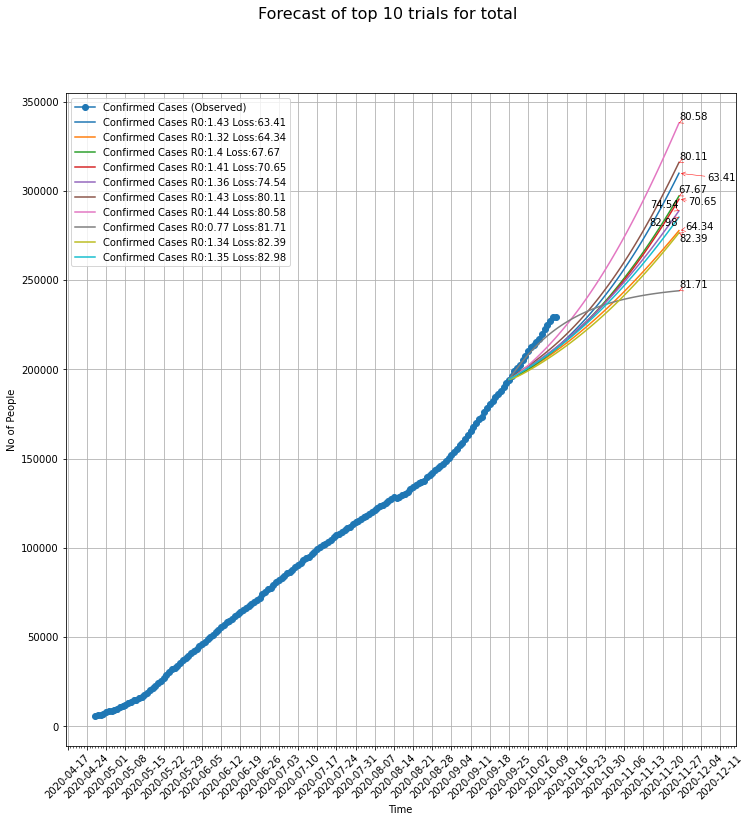

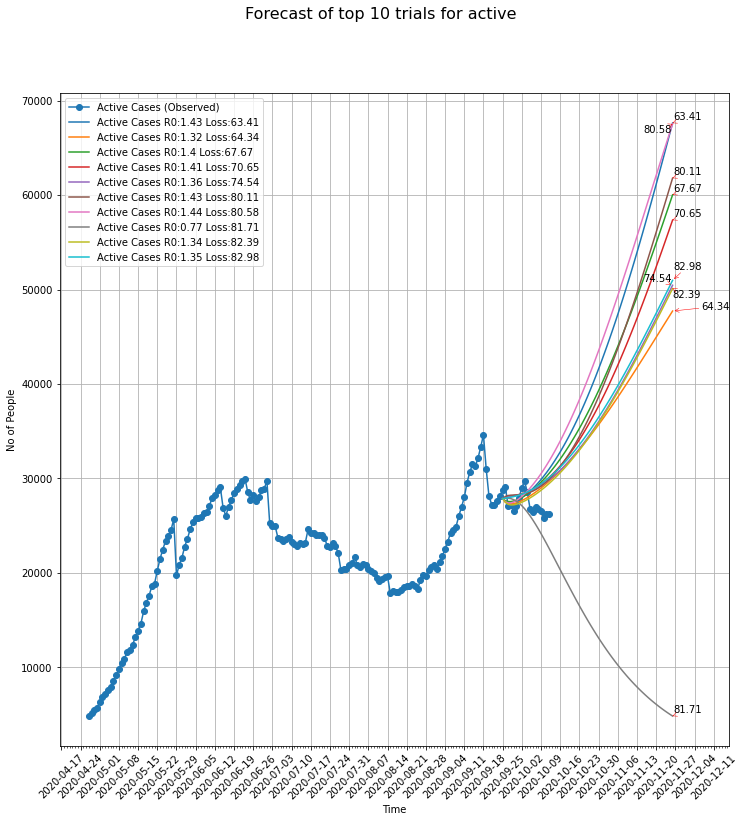

In [23]:
kforecasts = plot_top_k_trials(predictions_dict, train_fit='m2',
                               k=config['forecast']['num_trials_to_plot'],
                               which_compartments=config['forecast']['plot_topk_trials_for_columns'])

In [24]:
predictions_dict['m2']['plots']['forecasts_topk'] = {}
for column in config['forecast']['plot_topk_trials_for_columns']:
    predictions_dict['m2']['plots']['forecasts_topk'][column.name] = kforecasts[column]

## Uncertainty + Uncertainty Forecasts

In [25]:
uncertainty_args = {'predictions_dict': predictions_dict, **config['uncertainty']['uncertainty_params']}
uncertainty = config['uncertainty']['method'](**uncertainty_args)

100%|██████████| 100/100 [00:10<00:00,  9.61trial/s, best loss: nan]


In [26]:
uncertainty.beta_loss

{'active': 100.396976531598,
 'recovered': 40.978011016143434,
 'deceased': 52.020303731705184,
 'total': 25.12449546984907}

In [27]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predictions_dict['m2']['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

In [28]:
predictions_dict['m2']['beta'] = uncertainty.beta
predictions_dict['m2']['beta_loss'] = uncertainty.beta_loss
predictions_dict['m2']['deciles'] = uncertainty_forecasts

1157.0  
14     165222      9445  203433       1139.0  
15     166243      9502  204553       1120.0  
16     167266      9557  205653       1100.0  
17     168290      9612  206734       1081.0  
18     169313      9666  207795       1061.0  
19     170337      9720  208838       1043.0  
20     171359      9772  209860       1022.0  
21     172380      9824  210867       1007.0  
22     173398      9875  211853        986.0  
23     174413      9925  212822        969.0  
24     175424      9974  213771        949.0  
25     176432     10023  214705        934.0  
26     177436     10071  215621        916.0  
27     178434     10118  216519        898.0  
28     179428     10164  217401        882.0  
29     180417     10210  218267        866.0  
30     181399     10255  219116        849.0  
31     182375     10299  219948        832.0  
32     183345     10343  220766        818.0  
33     184309     10385  221565        799.0  
34     185266     10427  222352        787.0  
35  

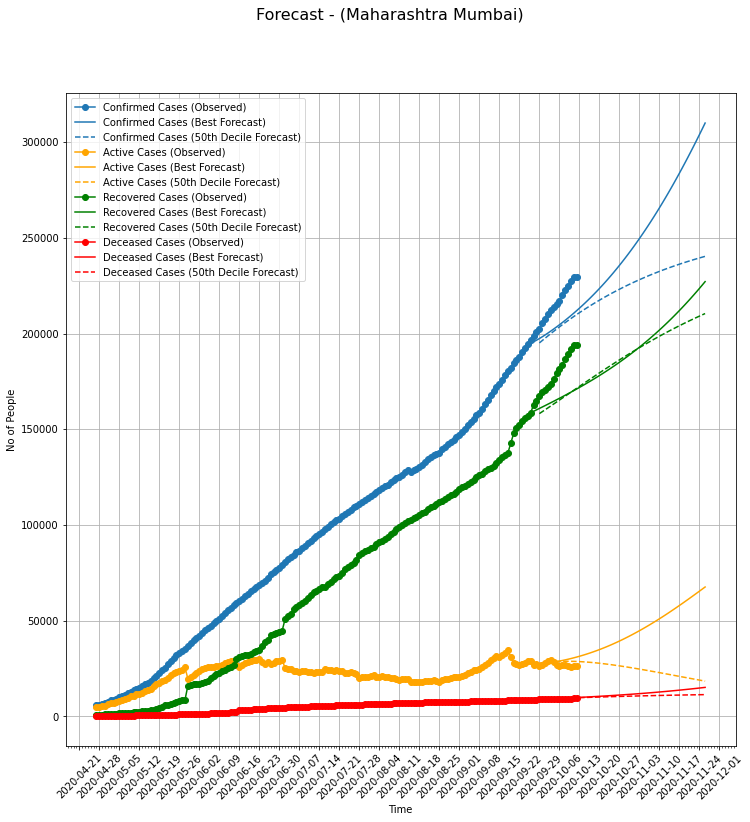

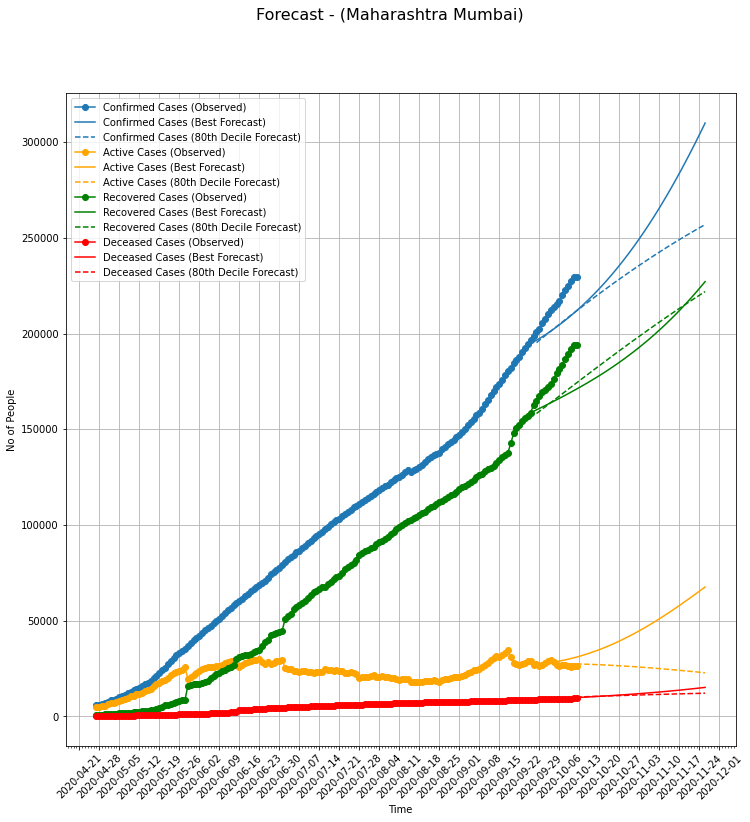

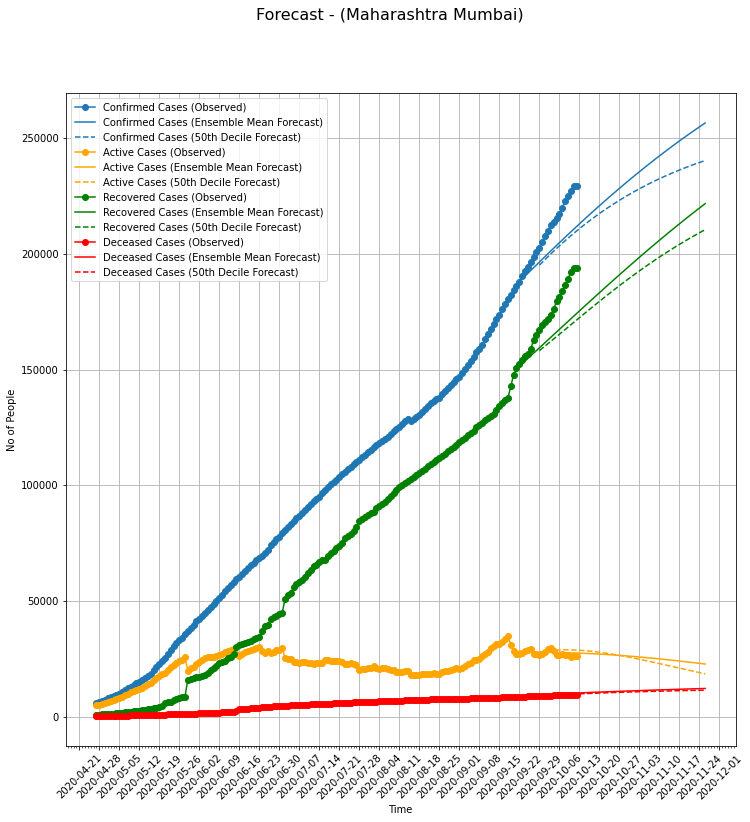

In [29]:
predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 50], error_bars=False)
predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 80], error_bars=False)
predictions_dict['m2']['plots']['forecast_ensemble_mean_50'] = plot_forecast(predictions_dict, 
                                                                             (config['fitting']['data']['dataloading_params']['state'], 
                                                                              config['fitting']['data']['dataloading_params']['district']),
                                                                             fits_to_plot=['ensemble_mean', 50], error_bars=False)

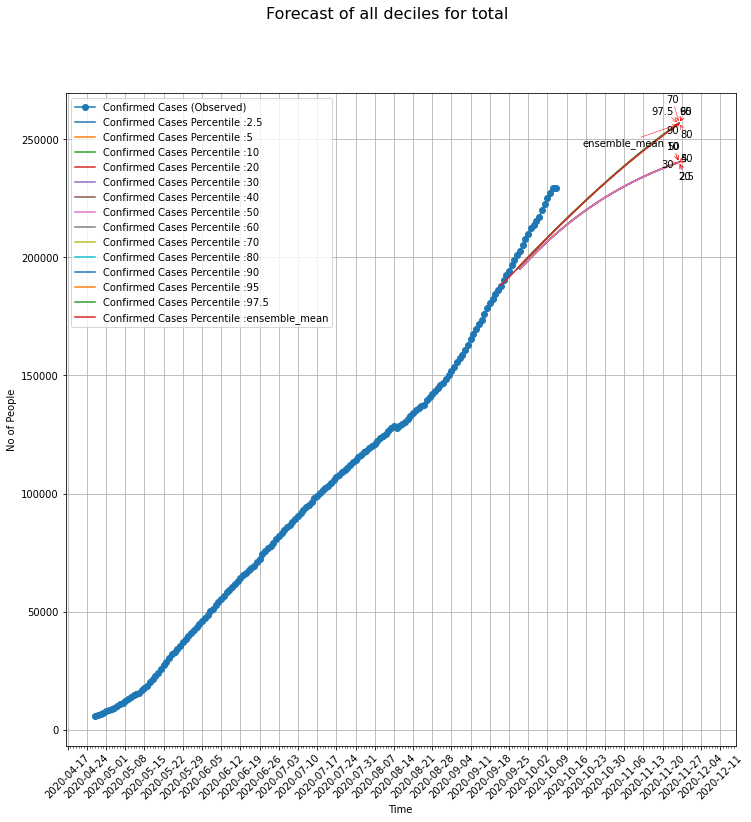

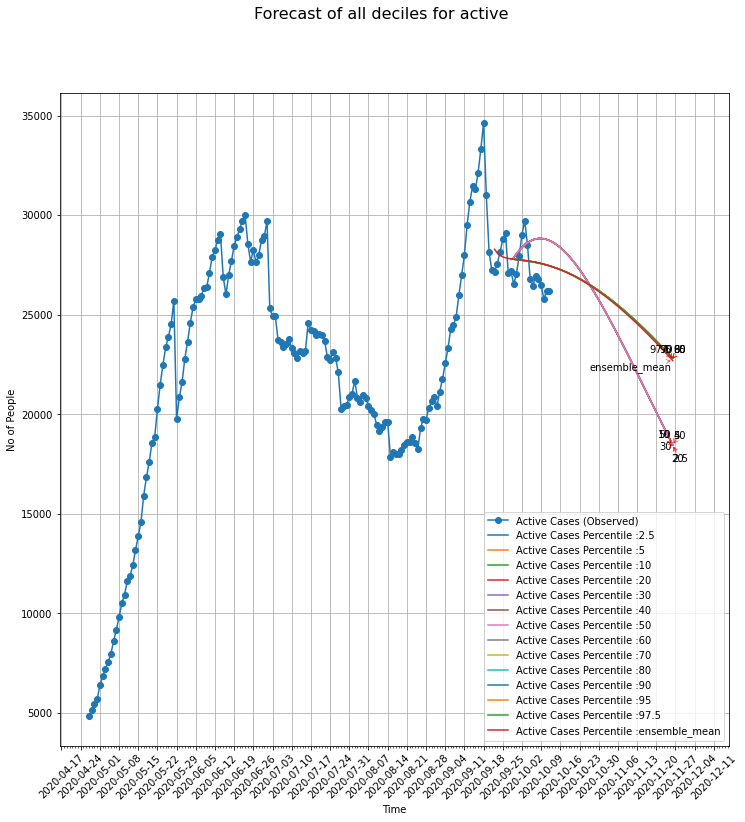

In [30]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['forecast']['plot_ptiles_for_columns'])
predictions_dict['m2']['plots']['forecasts_ptiles'] = {}
for column in config['forecast']['plot_ptiles_for_columns']:
    predictions_dict['m2']['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

## What If Scenarios - R0 Multipliers

getting forecasts ..
getting forecasts ..


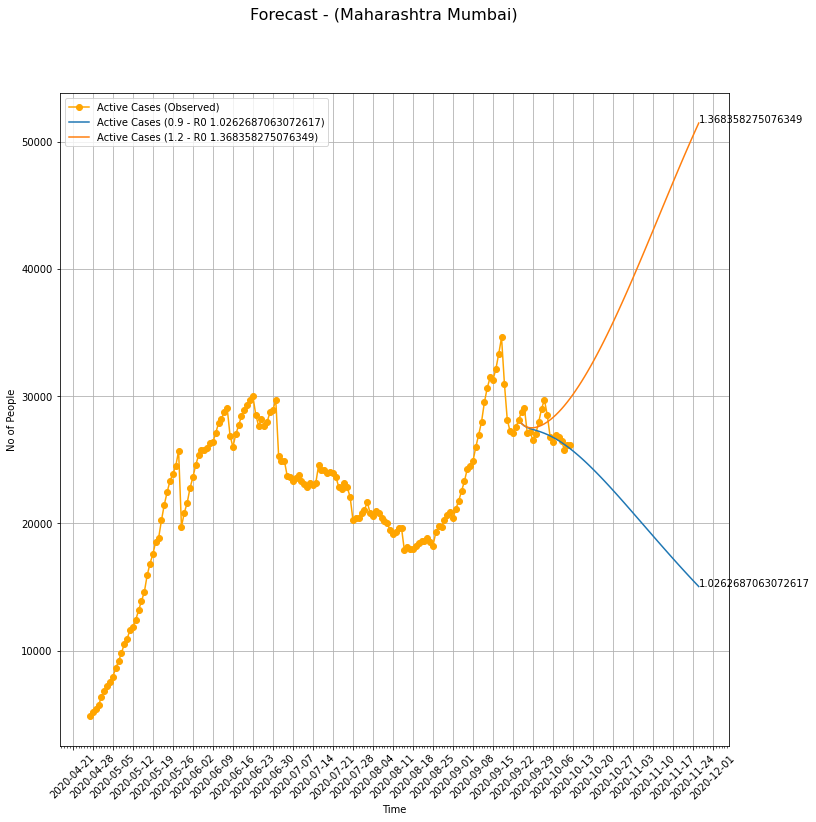

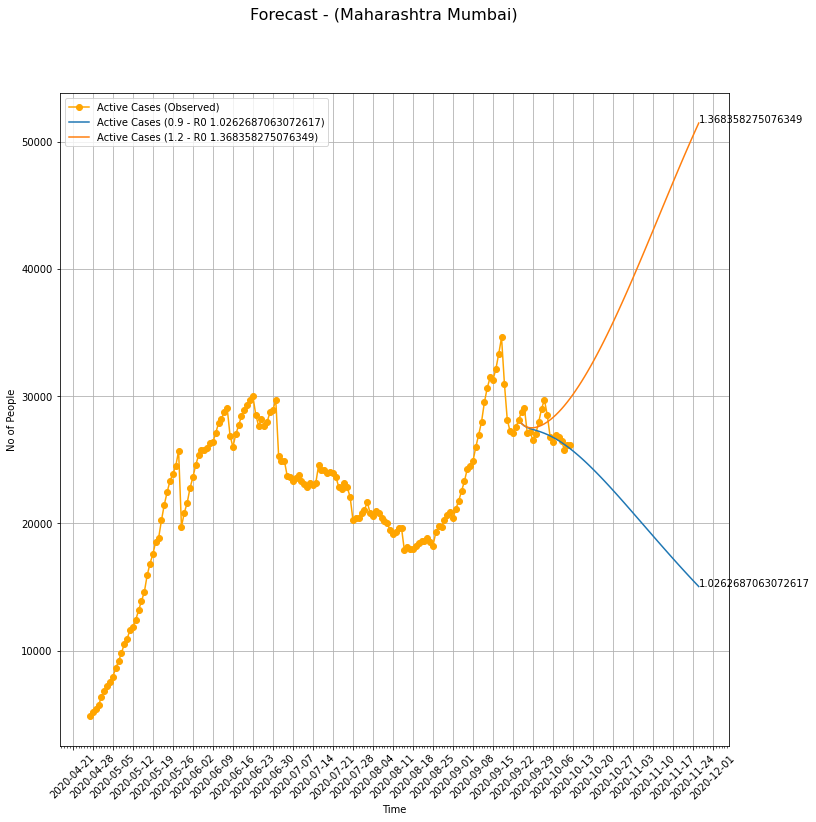

In [31]:
r0_mul_params= predictions_dict['m2']['deciles'][config['what_ifs']['percentile']]['params']
predictions_mul_dict = predict_r0_multipliers(predictions_dict, r0_mul_params, model=config['fitting']['model'],            days=config['forecast']['forecast_days'], multipliers=config['what_ifs']['multipliers'])
plot_r0_multipliers(predictions_dict, None, predictions_mul_dict, None, config['fitting']['data']['dataloading_params']['state'], config['fitting']['data']['dataloading_params']['district'])

## Create Report

In [32]:
save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

## Create Output

In [33]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

In [34]:
#log_wandb(predictions_dict)

## Create All Trials Output

In [35]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')

In [36]:
save_r0_mul(predictions_mul_dict, output_folder)

## Experiments

In [37]:
predictions_dict['m1'].keys()

dict_keys(['plots', 'best_params', 'default_params', 'variable_param_ranges', 'optimiser', 'df_prediction', 'df_district', 'df_train', 'df_val', 'df_loss', 'trials', 'data_last_date', 'df_district_unsmoothed', 'run_params', 'trials_processed'])

In [38]:
predictions_dict['m2'].keys()

dict_keys(['plots', 'best_params', 'default_params', 'variable_param_ranges', 'optimiser', 'df_prediction', 'df_district', 'df_train', 'df_val', 'df_loss', 'trials', 'data_last_date', 'df_district_unsmoothed', 'run_params', 'forecasts', 'trials_processed', 'beta', 'beta_loss', 'deciles'])

In [39]:
predictions_dict['m2']['df_district']

date        state district   total  active  recovered  deceased  \
0   2020-04-27  Maharashtra   Mumbai    5776    4846        711       219   
1   2020-04-28  Maharashtra   Mumbai    6169    5127        798       244   
2   2020-04-29  Maharashtra   Mumbai    6644    5438        936       270   
3   2020-04-30  Maharashtra   Mumbai    7061    5679       1092       290   
4   2020-05-01  Maharashtra   Mumbai    7812    6382       1134       296   
..         ...          ...      ...     ...     ...        ...       ...   
164 2020-10-08  Maharashtra   Mumbai  222784   26813     186675      9296   
165 2020-10-09  Maharashtra   Mumbai  225073   26506     189224      9343   
166 2020-10-10  Maharashtra   Mumbai  227276   25789     192096      9391   
167 2020-10-11  Maharashtra   Mumbai  229446   26208     193805      9433   
168 2020-10-12  Maharashtra   Mumbai  229446   26208     193805      9433   

        tested  other  daily_cases  
0          NaN    NaN        369.0  
1          NaN    NaN        393.0  
2          NaN    NaN        475.0  
3          NaN    NaN        417.0  
4          NaN    NaN        751.0  
..         ...    ...          ...  
164  1232838.0  430.0       2823.0  
165  1232838.0  434.0       2289.0  
166  1232838.0  437.0       2203.0  
167  1232838.0  441.0       2170.0  
168  1232838.0  441.0          0.0  

[169 rows x 10 columns]

In [40]:
from utils.fitting.data_weights import Data_Weights

In [41]:
weights = config['fitting']['data_weights']['weights']

In [42]:
start_date = config['fitting']['data_weights']['start_date']
end_date = config['fitting']['data_weights']['end_date']

In [43]:
df_district = predictions_dict['m1']['df_district']

In [44]:
df_data_weights = Data_Weights.make_weights_df(0, df_district, start_date, end_date, weights)

          date        state district   total  active  recovered  deceased  \
0   2020-04-27  Maharashtra   Mumbai    5776    4846        711       219   
1   2020-04-28  Maharashtra   Mumbai    6169    5127        798       244   
2   2020-04-29  Maharashtra   Mumbai    6644    5438        936       270   
3   2020-04-30  Maharashtra   Mumbai    7061    5679       1092       290   
4   2020-05-01  Maharashtra   Mumbai    7812    6382       1134       296   
..         ...          ...      ...     ...     ...        ...       ...   
164 2020-10-08  Maharashtra   Mumbai  222784   26813     186675      9296   
165 2020-10-09  Maharashtra   Mumbai  225073   26506     189224      9343   
166 2020-10-10  Maharashtra   Mumbai  227276   25789     192096      9391   
167 2020-10-11  Maharashtra   Mumbai  229446   26208     193805      9433   
168 2020-10-12  Maharashtra   Mumbai  229446   26208     193805      9433   

        tested  other  daily_cases  
0          NaN    NaN        369.0  
1

In [45]:
start_date, end_date, train_period, val_period, test_period = config['fitting']['split'].values()

In [47]:
df_data_weights_train, df_data_weights_val, df_data_weights_test = Data_Weights.implement_split(0, df_data_weights, train_period,val_period, test_period, start_date, end_date)

(          date        state district  total  active  recovered  deceased  \
 0   2020-04-27  Maharashtra   Mumbai    1.0     1.0        1.0       1.0   
 1   2020-04-28  Maharashtra   Mumbai    1.0     1.0        1.0       1.0   
 2   2020-04-29  Maharashtra   Mumbai    1.0     1.0        1.0       1.0   
 3   2020-04-30  Maharashtra   Mumbai    1.0     1.0        1.0       1.0   
 4   2020-05-01  Maharashtra   Mumbai    1.0     1.0        1.0       1.0   
 ..         ...          ...      ...    ...     ...        ...       ...   
 153 2020-09-27  Maharashtra   Mumbai    1.0     1.0        1.0       1.0   
 154 2020-09-28  Maharashtra   Mumbai    1.0     1.0        1.0       1.0   
 155 2020-09-29  Maharashtra   Mumbai    1.0     1.0        1.0       1.0   
 156 2020-09-30  Maharashtra   Mumbai    1.0     1.0        1.0       1.0   
 157 2020-10-01  Maharashtra   Mumbai    1.0     1.0        1.0       1.0   
 
         tested  other  daily_cases  
 0          NaN    NaN        369.0 

In [99]:
nppredictions_dict['m1']['df_district']['active'][-20:-1] - predictions_dict['m1']['df_district']['active'][-21:-2]

148    NaN
149    0.0
150    0.0
151    0.0
152    0.0
153    0.0
154    0.0
155    0.0
156    0.0
157    0.0
158    0.0
159    0.0
160    0.0
161    0.0
162    0.0
163    0.0
164    0.0
165    0.0
166    0.0
167    NaN
Name: active, dtype: float64

In [98]:
predictions_dict['m1']['df_district']['active'][-21:-2]

TypeError: 'numpy.ndarray' object is not callable